In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train_original = pd.read_csv('all-data.csv',delimiter=',',encoding='latin-1',header=None)
test_original = pd.read_csv('titles_yahoo_financial_616.csv',encoding='UTF-8')

In [3]:
train_original.columns = ['Sentiment','News Titles']

In [4]:
train_original

,Sentiment,News Titles
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


## Visualization

In [5]:
train_original.index = range(4846)
train_original['News Titles'].apply(lambda x: len(x.split(' '))).sum()

111989

/opt/anaconda3/envs/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


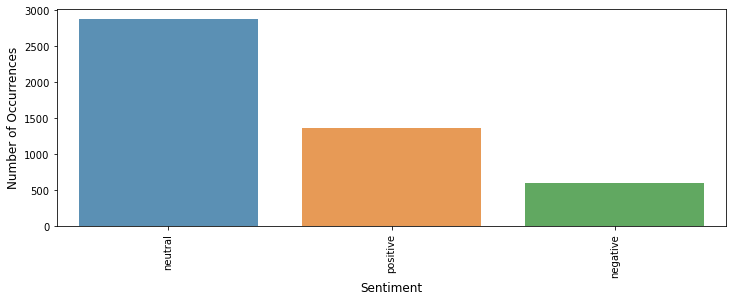

In [6]:
cnt_pro = train_original['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [7]:
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 
train_original.Sentiment = [sentiment[item] for item in train_original.Sentiment]

In [8]:
def print_message(index):
    example = train_original[train_original.index == index][['News Titles', 'Sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(2)

The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .
Message: 2


In [9]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
train_original['News Titles'] = train_original['News Titles'].apply(cleanText)

/opt/anaconda3/envs/python37/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [10]:
# train, test = train_test_split(train_original, test_size=0.01 , random_state=42)
import nltk
from nltk.corpus import stopwords

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train_original.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['News Titles']), tags=[r.Sentiment]), axis=1)

# The maximum number of words to be used
max_fatures = 500000

# Max number of words in each complaint
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_original['News Titles'].values)
X = tokenizer.texts_to_sequences(train_original['News Titles'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 4846 unique tokens.


In [11]:
X = tokenizer.texts_to_sequences(train_original['News Titles'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4846, 50)


In [12]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

/opt/anaconda3/envs/python37/lib/python3.7/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 4846/4846 [00:00<00:00, 2085960.30it/s]


In [13]:
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4846/4846 [00:00<00:00, 2798127.37it/s]


In [14]:
print(d2v_model)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [15]:
len(d2v_model.wv.vocab)

11683

In [16]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

In [17]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)

[('grievance', 0.770649254322052),
 ('op-pohjola', 0.7622226476669312),
 ('fund', 0.7547016739845276),
 ('verification', 0.7500354051589966),
 ('karhinen', 0.7335039973258972),
 ('wrt1v', 0.7330789566040039),
 ('organization', 0.7258241176605225),
 ('negotiated', 0.7166264057159424),
 ('property', 0.7142353057861328),
 ('annual', 0.7061365842819214)]

In [84]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# %matplotlib inline

# def tsne_plot(model):
#     "Creates and TSNE model and plots it"
#     labels = []
#     tokens = []

#     for word in d2v_model.wv.vocab:
#         tokens.append(model[word])
#         labels.append(word)
    
#     tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
#     new_values = tsne_model.fit_transform(tokens)

#     x = []
#     y = []
#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])
        
#     plt.figure(figsize=(16, 16)) 
#     for i in range(len(x)):
#         plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
#     plt.show()

In [85]:
# tsne_plot(d2v_model)

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

2024-05-05 20:35:16.442700: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 20:35:16.444503: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 20)            233680    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                14200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 248,033
Trainable params: 248,033
Non-trainable params: 0
_________________________________________________________________


In [19]:
Y = pd.get_dummies(train_original['Sentiment']).values
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X.shape,Y.shape)
# print(X_test.shape,Y_test.shape)

(4846, 50) (4846, 3)


In [20]:
batch_size = 32
history=model.fit(X, Y, epochs =50, batch_size=batch_size, verbose = 2)

/opt/anaconda3/envs/python37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
 - 32s - loss: 0.5083 - acc: 0.7548
Epoch 2/50
 - 28s - loss: 0.3675 - acc: 0.8271
Epoch 3/50
 - 31s - loss: 0.2374 - acc: 0.8974
Epoch 4/50
 - 31s - loss: 0.1282 - acc: 0.9547
Epoch 5/50
 - 29s - loss: 0.0781 - acc: 0.9754
Epoch 6/50
 - 27s - loss: 0.0537 - acc: 0.9840
Epoch 7/50
 - 30s - loss: 0.0582 - acc: 0.9809
Epoch 8/50
 - 35s - loss: 0.0356 - acc: 0.9890
Epoch 9/50
 - 30s - loss: 0.0307 - acc: 0.9902
Epoch 10/50
 - 33s - loss: 0.0227 - acc: 0.9940
Epoch 11/50
 - 31s - loss: 0.0193 - acc: 0.9946
Epoch 12/50
 - 33s - loss: 0.0204 - acc: 0.9948
Epoch 13/50
 - 29s - loss: 0.0165 - acc: 0.9956
Epoch 14/50
 - 31s - loss: 0.0150 - acc: 0.9952
Epoch 15/50
 - 27s - loss: 0.0152 - acc: 0.9950
Epoch 16/50
 - 26s - loss: 0.0105 - acc: 0.9972
Epoch 17/50
 - 29s - loss: 0.0095 - acc: 0.9975
Epoch 18/50
 - 30s - loss: 0.0089 - acc: 0.9973
Epoch 19/50
 - 29s - loss: 0.0098 - acc: 0.9972
Epoch 20/50
 - 29s - loss: 0.0091 - acc: 0.9977
Epoch 21/50
 - 33s - loss: 0.0077 - acc: 0.9975
E

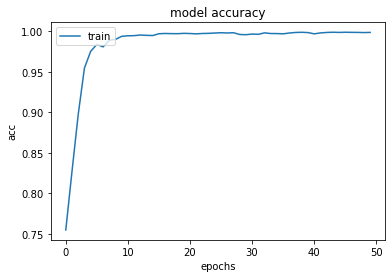

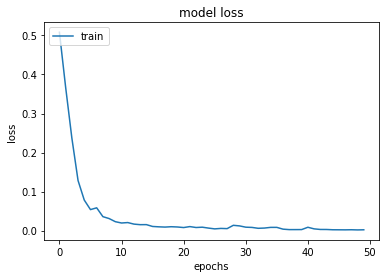

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [22]:
# evaluate the model
_, train_acc = model.evaluate(X, Y, verbose=2)
# _, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f' % (train_acc))

Train: 0.999


In [23]:
# predict probabilities for test set
yhat_probs = model.predict(X, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X, verbose=0)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

[[1.8207461e-04 9.9978584e-01 3.2044165e-05]
 [2.7568474e-05 9.9996412e-01 8.2872884e-06]
 [3.2140164e-07 3.8268166e-08 9.9999964e-01]
 ...
 [2.0952470e-04 5.9316444e-05 9.9973112e-01]
 [3.0190096e-05 7.0596843e-06 9.9996281e-01]
 [2.1415001e-06 5.2572994e-07 9.9999738e-01]]
[1 1 2 ... 2 2 2]


In [25]:
import numpy as np
rounded_labels=np.argmax(Y, axis=1)
rounded_labels

array([1, 1, 2, ..., 2, 2, 2])

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[1359,    4,    0],
       [   2, 2877,    0],
       [   0,    0,  604]])

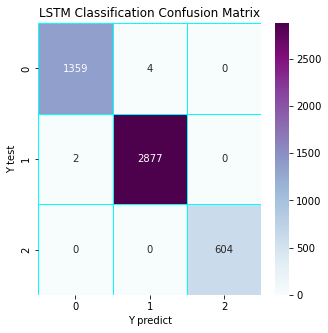

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [35]:
# validation_size = 610

# X_validate = X_test[-validation_size:]
# Y_validate = Y_test[-validation_size:]
# X_test = X_test[:-validation_size]
# Y_test = Y_test[:-validation_size]
# score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

# print("score: %.2f" % (score))
# print("acc: %.2f" % (acc))

In [28]:
model.save('Mymodel.h5')

In [29]:
test_original['seq'] = tokenizer.texts_to_sequences(test_original['News Titles'])
test_original['padded'] = test_original['seq'].apply(lambda x: pad_sequences([x], maxlen=X.shape[1], dtype='int32', value=0))
test_original['pred'] = test_original['padded'].apply(lambda x: model.predict(x))

In [30]:
test_original['pred']

0              [[0.149698, 0.837186, 0.013116026]]
1          [[0.03617515, 0.94495785, 0.018867027]]
2         [[0.003935251, 0.99438727, 0.001677445]]
3       [[2.887175e-07, 0.9999995, 1.8791957e-07]]
4      [[1.0627945e-05, 4.2272122e-06, 0.9999851]]
                          ...                     
611     [[0.029375194, 0.97025204, 0.00037275904]]
612     [[6.026351e-06, 0.9999883, 5.5669834e-06]]
613         [[0.014755661, 0.8685657, 0.11667872]]
614         [[0.45050827, 0.49404788, 0.05544385]]
615       [[0.96125114, 0.03822637, 0.0005225214]]
Name: pred, Length: 616, dtype: object

In [31]:
labels = ['0','1','2']
test_original['labels'] = test_original['pred'].apply(lambda x: labels[np.argmax(x)])

In [32]:
test_original['flag'] = test_original['labels'].apply(lambda x: 'positive' if x == '0' else ('neutral' if x == '1' else 'negative'))

In [33]:
test_original['labels'].value_counts()

1    408
2    104
0    104
Name: labels, dtype: int64

In [34]:
test_original[['News Titles','flag']].to_csv('LSTM_output.csv', index=False)